# Bayesian Optimisation of a LightGBM Model

In [1]:
import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer


# Evaluation of the model
#from sklearn.model_selection import KFold


##Data

Data details: https://www.kaggle.com/datasets/uciml/caravan-insurance-challenge

Queremos hacer una clasificación en Número de pólizas de casas móviles

In [2]:
link = 'https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/data/caravan-insurance-challenge.csv?raw=true'
data = pd.read_csv(link)
print(data.shape)
data.head()


(9822, 87)


,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0


In [3]:
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,)) # Número de pólizas de casas móviles
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,)) # Número de pólizas de casas móviles

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


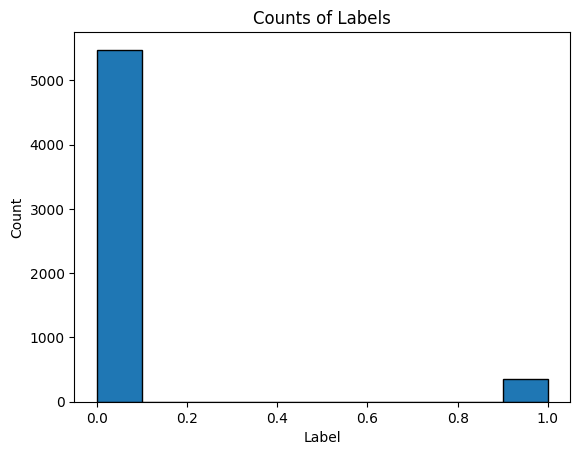

In [4]:
plt.hist(labels, edgecolor = 'k');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

## Gradient Boosting Machine Default Model

See details: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [5]:
# Model with default hyperparameters
model = lgb.LGBMClassifier(force_row_wise=True, verbose=-1)

In [6]:
start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7089.
The baseline training time is 0.8883 seconds


El AUC varía en valor de 0 a 1. Un modelo cuyas predicciones son un 100% incorrectas tiene un AUC de 0.0; uno cuyas predicciones son un 100% correctas tiene un AUC de 1.0.

## Random Search


In [7]:
help(lgb.LGBMClassifier())

Help on LGBMClassifier in module lightgbm.sklearn object:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.Random

In [8]:
# Hyperparameter grid
param_fix = {'force_row_wise' : True, 'verbose' : -1}

param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': list(range(30, 50)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'class_weight': [None, 'balanced'],
    'is_unbalance' : [True,False],
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample' : list(np.linspace(0.5, 1, 100)),
    }



LightGBM utiliza una técnica novedosa de muestreo de un lado basado en gradiente (GOSS)

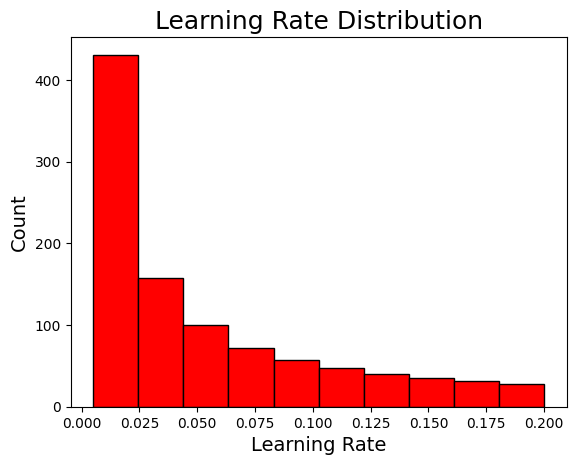

In [9]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

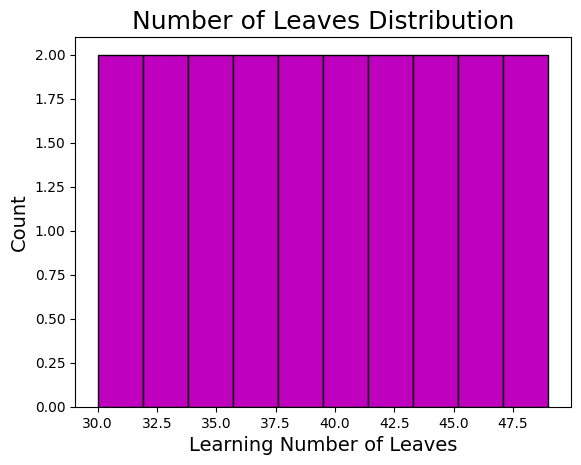

In [10]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

## Sampling from Hyperparameter Domain


In [11]:
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'boosting_type': 'gbdt',
 'num_leaves': 30,
 'learning_rate': 0.009332310113975877,
 'subsample_for_bin': 60000,
 'min_child_samples': 80,
 'class_weight': None,
 'is_unbalance': True,
 'reg_alpha': 0.44897959183673464,
 'reg_lambda': 0.14285714285714285,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.8333333333333334}

In [12]:
def Merge(dict_1, dict_2):
	result = dict_1 | dict_2
	return result

params = Merge(params,param_fix)
params

{'boosting_type': 'gbdt',
 'num_leaves': 30,
 'learning_rate': 0.009332310113975877,
 'subsample_for_bin': 60000,
 'min_child_samples': 80,
 'class_weight': None,
 'is_unbalance': True,
 'reg_alpha': 0.44897959183673464,
 'reg_lambda': 0.14285714285714285,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.8333333333333334,
 'force_row_wise': True,
 'verbose': -1}

In [13]:
# Model with random hyperparameters
model = lgb.LGBMClassifier(**params)

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7153.
The baseline training time is 0.7498 seconds


## Cross Validation with Early Stopping in LightGBM


See details: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html

In [14]:
%%time

train_set = lgb.Dataset(features, label = labels)

# Perform cross validation with 10 folds
r = lgb.cv(params, train_set, num_boost_round = 100, nfold = 10, metrics = 'auc', seed = 50)

# Highest score
r_best = np.max(r['valid auc-mean'])

# Loss must be minimized
loss = 1 - r_best

# Standard deviation of best score
r_best_std = r['valid auc-stdv'][np.argmax(r['valid auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The loss was {}.'.format(loss))
print('The ideal number of iterations was {}.'.format(np.argmax(r['valid auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.74717 with std of 0.04957.
The loss was 0.25283224263297177.
The ideal number of iterations was 34.
CPU times: user 19.3 s, sys: 118 ms, total: 19.5 s
Wall time: 29.8 s


In [15]:
random_estimators = int(np.argmax(r['valid auc-mean']) + 1)

# Model with random hyperparameters
best_random_model = lgb.LGBMClassifier(**params, n_estimators=random_estimators, n_jobs = -1,
                                       objective = 'binary', random_state = 50)

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7153.
The baseline training time is 0.6110 seconds


## Results Dataframe

In [16]:
# Dataframe to hold cv results
MAX_EVALS = 100
N_FOLDS = 10
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))
random_results

,loss,params,iteration,estimators,time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN


## Objective Function

In [17]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 100, nfold = n_folds, metrics = 'auc',
           seed = 50)
    end = timer()

    best_score = np.max(cv_results['valid auc-mean'])

    # Loss must be minimized
    loss = 1 - best_score

    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['valid auc-mean']) + 1)

    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

# Random Search Implementation


In [18]:
#%%capture
#%%time
#random.seed(50)
train_set = lgb.Dataset(features, label = labels, free_raw_data = False)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    params = Merge(params,param_fix)

    if i%10 == 0:
      print('i = {} with {}'.format(i,params))

    results_list = random_objective(params, i)

    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

i = 0 with {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.11118532619062516, 'subsample_for_bin': 200000, 'min_child_samples': 450, 'class_weight': None, 'is_unbalance': False, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.8163265306122448, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.5858585858585859, 'force_row_wise': True, 'verbose': -1}
i = 10 with {'boosting_type': 'dart', 'num_leaves': 30, 'learning_rate': 0.13080028050336373, 'subsample_for_bin': 140000, 'min_child_samples': 225, 'class_weight': None, 'is_unbalance': True, 'reg_alpha': 0.5714285714285714, 'reg_lambda': 0.12244897959183673, 'colsample_bytree': 0.6888888888888889, 'subsample': 0.8535353535353536, 'force_row_wise': True, 'verbose': -1}
i = 20 with {'boosting_type': 'dart', 'num_leaves': 46, 'learning_rate': 0.016602010806191888, 'subsample_for_bin': 280000, 'min_child_samples': 40, 'class_weight': 'balanced', 'is_unbalance': False, 'reg_alpha': 0.5918367346938775, 'reg_lambda': 0.469387

In [19]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results

,loss,params,iteration,estimators,time
0,0.232762,"{'boosting_type': 'dart', 'num_leaves': 46, 'l...",99,100,2.92413
1,0.236152,"{'boosting_type': 'gbdt', 'num_leaves': 42, 'l...",70,100,1.525208
2,0.237154,"{'boosting_type': 'dart', 'num_leaves': 44, 'l...",38,99,4.553146
3,0.237499,"{'boosting_type': 'dart', 'num_leaves': 36, 'l...",31,99,2.315944
4,0.237521,"{'boosting_type': 'dart', 'num_leaves': 40, 'l...",58,53,2.997183
...,...,...,...,...,...
95,0.266471,"{'boosting_type': 'gbdt', 'num_leaves': 48, 'l...",88,12,2.210694
96,0.267445,"{'boosting_type': 'gbdt', 'num_leaves': 38, 'l...",90,29,2.026612
97,0.27016,"{'boosting_type': 'dart', 'num_leaves': 46, 'l...",20,91,5.894809
98,0.271244,"{'boosting_type': 'dart', 'num_leaves': 40, 'l...",57,17,6.276262


## Random Search Performance


In [20]:
random_results.loc[0, 'params']

{'boosting_type': 'dart',
 'num_leaves': 46,
 'learning_rate': 0.08305352042021888,
 'subsample_for_bin': 260000,
 'min_child_samples': 215,
 'class_weight': None,
 'is_unbalance': False,
 'reg_alpha': 0.9387755102040816,
 'reg_lambda': 0.14285714285714285,
 'colsample_bytree': 0.6444444444444444,
 'subsample': 0.8181818181818182,
 'force_row_wise': True,
 'verbose': -1}

In [21]:
# Find the best parameters and number of estimators
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators,
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

The best model from random search scores 0.7053 on the test data.
This was achieved using 99 search iterations.


<Axes: >

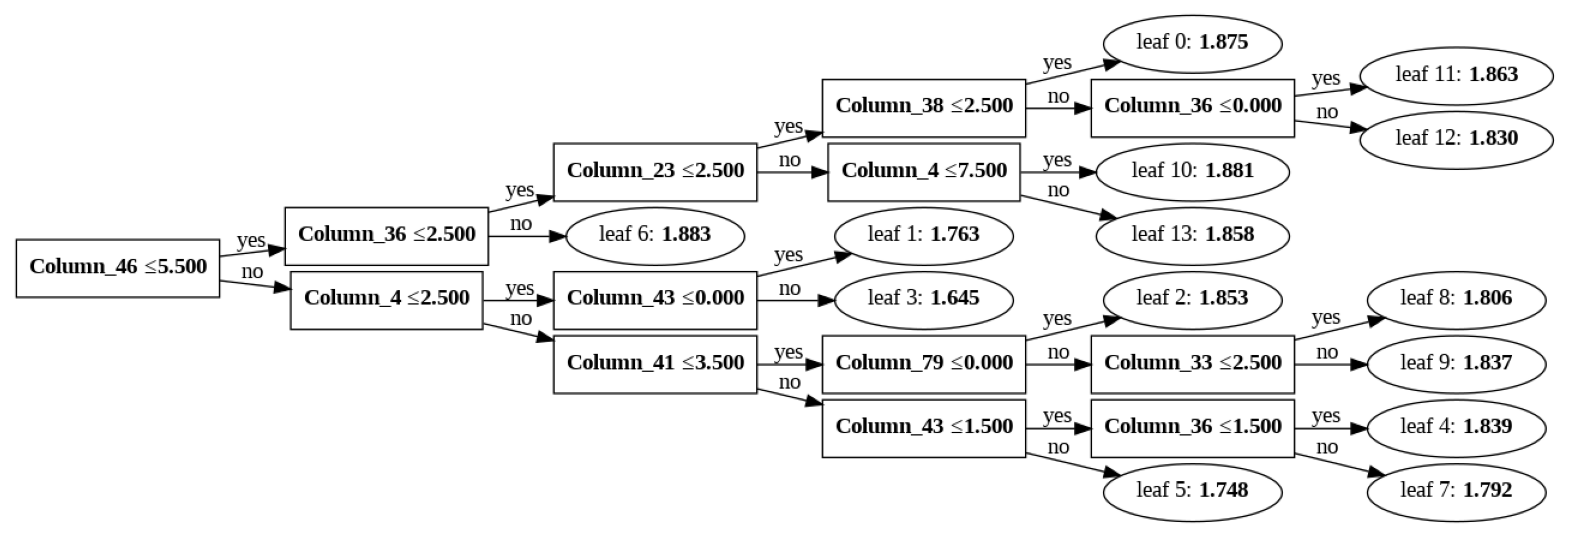

In [22]:
lgb.plot_tree(best_random_model, figsize=(20,10))

# Bayesian Hyperparameter Optimization using Hyperopt

## Objective Function

In [23]:
# Dataframe to hold cv results
results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'train_time'],
                       index = list(range(MAX_EVALS)))

results

,loss,params,iteration,estimators,train_time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN


In [24]:
from hyperopt import STATUS_OK

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""

    # Keep track of evals
    global ITERATION

    ITERATION += 1

    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])

    start = timer()

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 100, nfold = n_folds,
                       metrics = 'auc', seed = 50)

    run_time = timer() - start

    # Extract the best score
    best_score = np.max(cv_results['valid auc-mean'])

    # Loss must be minimized
    loss = 1 - best_score

    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['valid auc-mean']) + 1)

    # Write to a DataFrame results
    results.loc[ITERATION-1, :]=[loss, params, ITERATION, n_estimators, run_time]

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators,
            'train_time': run_time, 'status': STATUS_OK}

## Domain Space

In [25]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [26]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

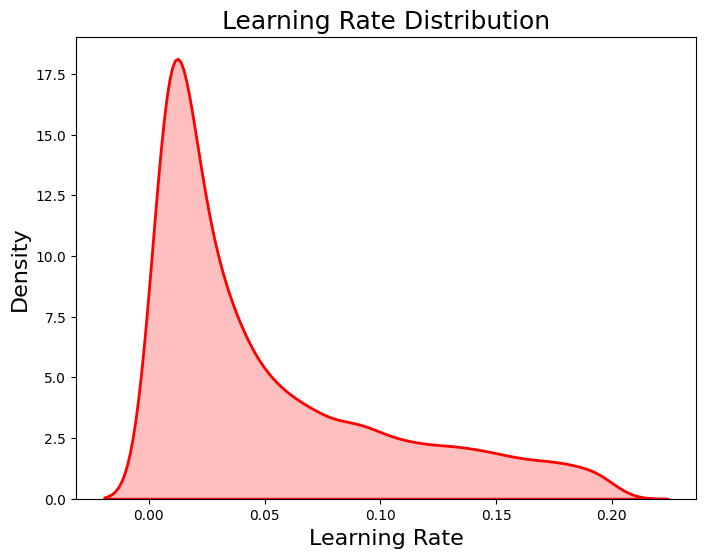

In [27]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, fill=True);
plt.title('Learning Rate Distribution', size = 18);
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

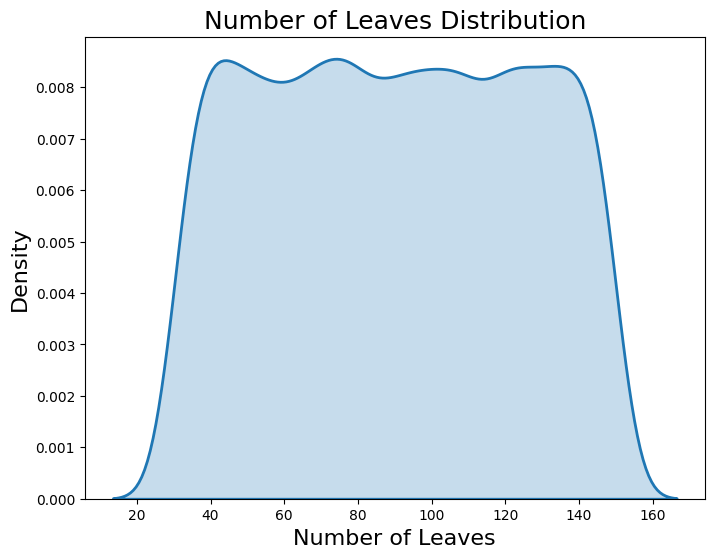

In [28]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])

# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, fill=True);
plt.title('Number of Leaves Distribution', size = 18);
plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

## Complete Bayesian Domain

In [29]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'is_unbalance' : hp.choice('is_unbalance', [True, False]),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'subsample' : hp.uniform('subsample', 0.5, 1),
    }


In [30]:
#Add the fix parameters
space = Merge(space, param_fix)
space

{'boosting_type': <hyperopt.pyll.base.Apply at 0x798cc1679cf0>,
 'num_leaves': <hyperopt.pyll.base.Apply at 0x798cc1678790>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x798cc167bcd0>,
 'subsample_for_bin': <hyperopt.pyll.base.Apply at 0x798cc167be20>,
 'min_child_samples': <hyperopt.pyll.base.Apply at 0x798cc167b9a0>,
 'class_weight': <hyperopt.pyll.base.Apply at 0x798cc167b8b0>,
 'is_unbalance': <hyperopt.pyll.base.Apply at 0x798cc1679750>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x798cc167b220>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x798cc167b340>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x798cc167b700>,
 'subsample': <hyperopt.pyll.base.Apply at 0x798cc1679600>,
 'force_row_wise': True,
 'verbose': -1}

## Example of Sampling from the Domain

In [31]:
# Sample from the full space
x = sample(space)
x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9164185783040745,
 'force_row_wise': True,
 'is_unbalance': True,
 'learning_rate': 0.11702260675095846,
 'min_child_samples': 425.0,
 'num_leaves': 87.0,
 'reg_alpha': 0.1486434197897908,
 'reg_lambda': 0.20498235181357016,
 'subsample': 0.6174661906980663,
 'subsample_for_bin': 20000.0,
 'verbose': -1}

## Optimization Algorithm

In [32]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

## Results History

In [33]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

## Bayesian Optimization

In [34]:
from hyperopt import fmin

In [35]:
%%time
#%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.default_rng(50))


100%|██████████| 100/100 [05:10<00:00,  3.11s/trial, best loss: 0.23178046407716935]
CPU times: user 9min 10s, sys: 4.67 s, total: 9min 14s
Wall time: 5min 10s


In [36]:
bayes_trials.results

[{'loss': 0.24928423016546453,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.9388624212214933,
   'force_row_wise': True,
   'is_unbalance': True,
   'learning_rate': 0.1415789467293421,
   'min_child_samples': 165,
   'num_leaves': 138,
   'reg_alpha': 0.5125902292261353,
   'reg_lambda': 0.32707245520737505,
   'subsample': 0.811135297575367,
   'subsample_for_bin': 180000,
   'verbose': -1},
  'iteration': 1,
  'estimators': 44,
  'train_time': 3.636350207000021,
  'status': 'ok'},
 {'loss': 0.24422290493747245,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.8856050179833065,
   'force_row_wise': True,
   'is_unbalance': True,
   'learning_rate': 0.020524302758474822,
   'min_child_samples': 155,
   'num_leaves': 98,
   'reg_alpha': 0.8384626374035719,
   'reg_lambda': 0.4043156752938263,
   'subsample': 0.6334598245354541,
   'subsample_for_bin': 220000,
   'verbose': -1},
  'iteration': 2,
  'estima

In [37]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.23178046407716935,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.6280527249554099,
   'force_row_wise': True,
   'is_unbalance': False,
   'learning_rate': 0.09464821862926409,
   'min_child_samples': 260,
   'num_leaves': 131,
   'reg_alpha': 0.9970695786693627,
   'reg_lambda': 0.07197756672413418,
   'subsample': 0.7863995353881245,
   'subsample_for_bin': 240000,
   'verbose': -1},
  'iteration': 66,
  'estimators': 67,
  'train_time': 2.831835174000048,
  'status': 'ok'},
 {'loss': 0.2336987848155716,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.8135222647779164,
   'force_row_wise': True,
   'is_unbalance': True,
   'learning_rate': 0.07961938180408595,
   'min_child_samples': 265,
   'num_leaves': 140,
   'reg_alpha': 0.578364058002945,
   'reg_lambda': 0.44603175351362834,
   'subsample': 0.6002753756371637,
   'subsample_for_bin': 200000,
   'verbose': -1},
  'iteration': 85,
  'es

In [38]:
# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.23178,"{'boosting_type': 'dart', 'class_weight': None...",66,67,2.831835
1,0.233699,"{'boosting_type': 'dart', 'class_weight': None...",85,96,4.643237
2,0.234306,"{'boosting_type': 'dart', 'class_weight': None...",31,27,4.837131
3,0.235181,"{'boosting_type': 'dart', 'class_weight': None...",43,47,3.064727
4,0.235214,"{'boosting_type': 'dart', 'class_weight': None...",69,95,2.908067


In [39]:
results.loc[0,'params']

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.6280527249554099,
 'force_row_wise': True,
 'is_unbalance': False,
 'learning_rate': 0.09464821862926409,
 'min_child_samples': 260,
 'num_leaves': 131,
 'reg_alpha': 0.9970695786693627,
 'reg_lambda': 0.07197756672413418,
 'subsample': 0.7863995353881245,
 'subsample_for_bin': 240000,
 'verbose': -1}

## Evaluate Best Results

In [40]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = results.loc[0, 'params'].copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators,
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.6280527249554099,
               force_row_wise=True, is_unbalance=False,
               learning_rate=0.09464821862926409, min_child_samples=260,
               n_estimators=67, num_leaves=131, objective='binary',
               random_state=50, reg_alpha=0.9970695786693627,
               reg_lambda=0.07197756672413418, subsample=0.7863995353881245,
               subsample_for_bin=240000, verbose=-1)

In [41]:
# Evaluate on the testing data
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72676 AUC ROC on the test set.
This was achieved after 66 search iterations


<Axes: >

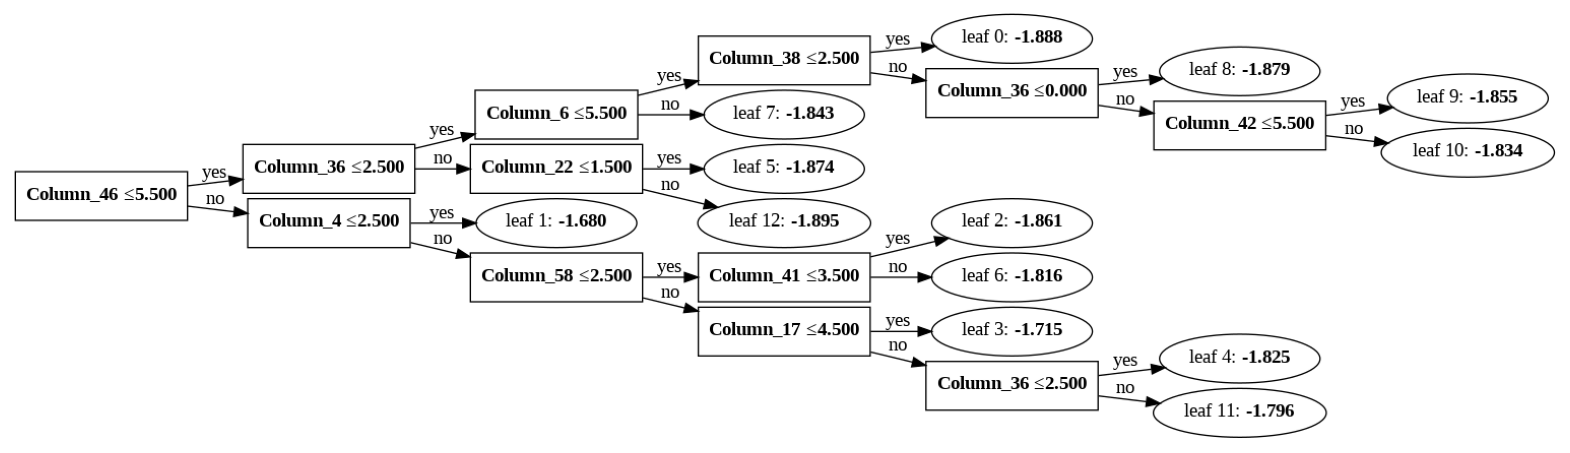

In [42]:
lgb.plot_tree(best_bayes_model, figsize=(20,10))

# Comparison to Random Search

In [43]:
best_random_params['method'] = 'random search'
best_bayes_params['method'] = 'Bayesian optimization'

best_params = pd.DataFrame([best_random_params, best_bayes_params])
best_params

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,class_weight,is_unbalance,reg_alpha,reg_lambda,colsample_bytree,subsample,force_row_wise,verbose,method
0,dart,46,0.083054,260000,215,None,False,0.938776,0.142857,0.644444,0.818182,True,-1,random search
1,dart,131,0.094648,240000,260,None,False,0.997070,0.071978,0.628053,0.786400,True,-1,Bayesian optimization


In [44]:
# Create a new dataframe for storing parameters
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())

random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,class_weight,is_unbalance,reg_alpha,reg_lambda,colsample_bytree,subsample,force_row_wise,verbose,loss,iteration
0,dart,46,0.083054,260000,215,None,False,0.938776,0.142857,0.644444,0.818182,True,-1,0.232762,99
1,gbdt,42,0.017809,280000,215,balanced,False,0.367347,0.367347,0.644444,0.722222,True,-1,0.236152,70
2,dart,44,0.043684,240000,265,balanced,True,0.816327,0.489796,0.644444,0.611111,True,-1,0.237154,38
3,dart,36,0.071385,20000,400,balanced,False,0.44898,0.22449,0.822222,0.818182,True,-1,0.237499,31
4,dart,40,0.103652,100000,230,balanced,True,0.020408,0.061224,0.688889,0.555556,True,-1,0.237521,58


In [45]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(results.loc[0, 'params'].keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(params.values())

bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,boosting_type,class_weight,colsample_bytree,force_row_wise,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin,verbose,loss,iteration
0,dart,None,0.628053,True,False,0.094648,260,131,0.99707,0.071978,0.7864,240000,-1,0.23178,66
1,dart,None,0.813522,True,True,0.079619,265,140,0.578364,0.446032,0.600275,200000,-1,0.233699,85
2,dart,None,0.618616,True,True,0.108353,260,46,0.566347,0.581358,0.837396,140000,-1,0.234306,31
3,dart,None,0.600343,True,False,0.091678,265,137,0.157406,0.62449,0.603872,240000,-1,0.235181,43
4,dart,None,0.629854,True,False,0.068762,235,142,0.994075,0.607669,0.878503,220000,-1,0.235214,69


Learning Rates

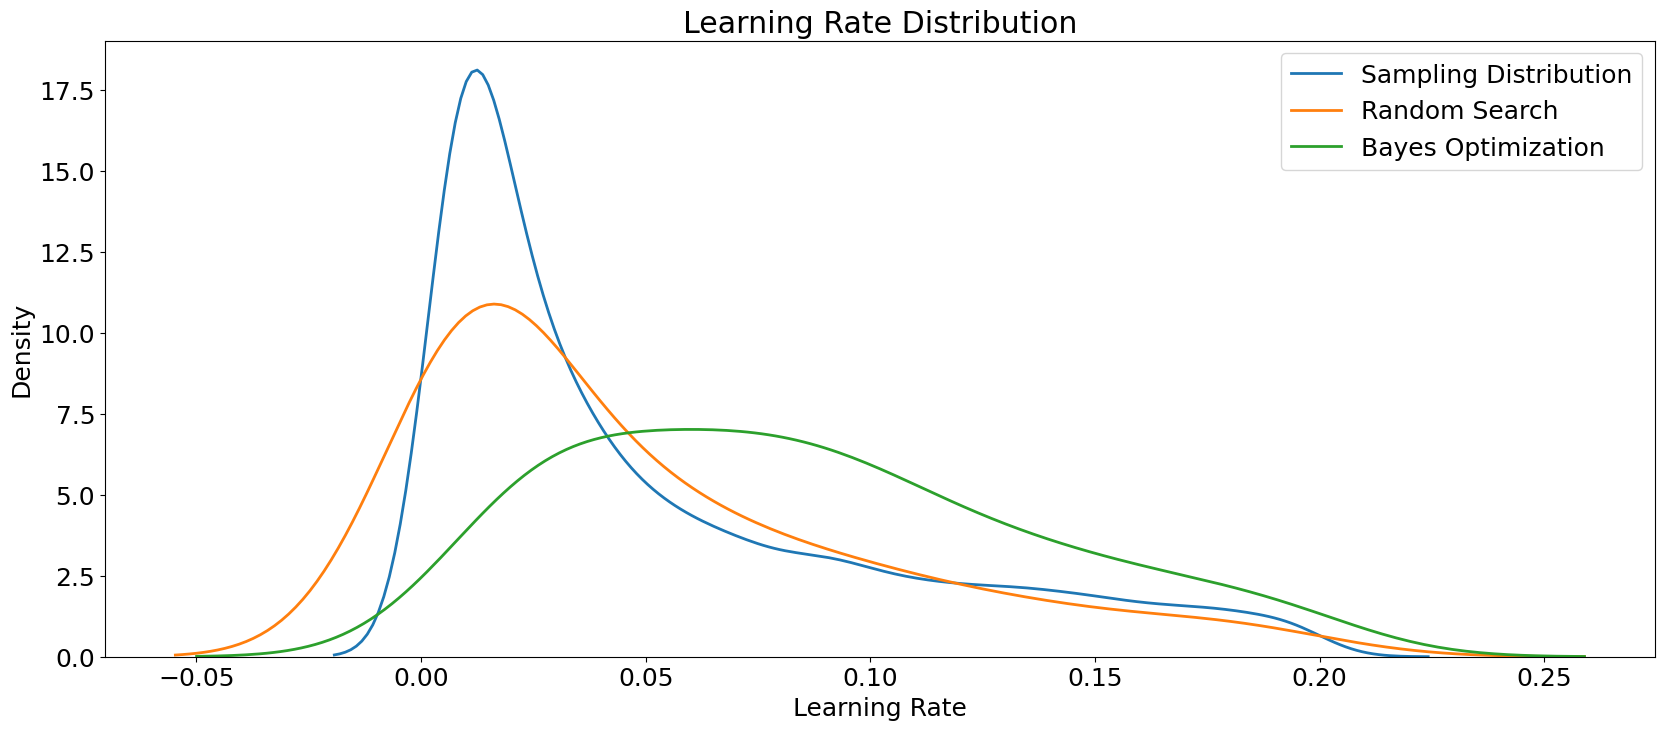

In [46]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

Class weight

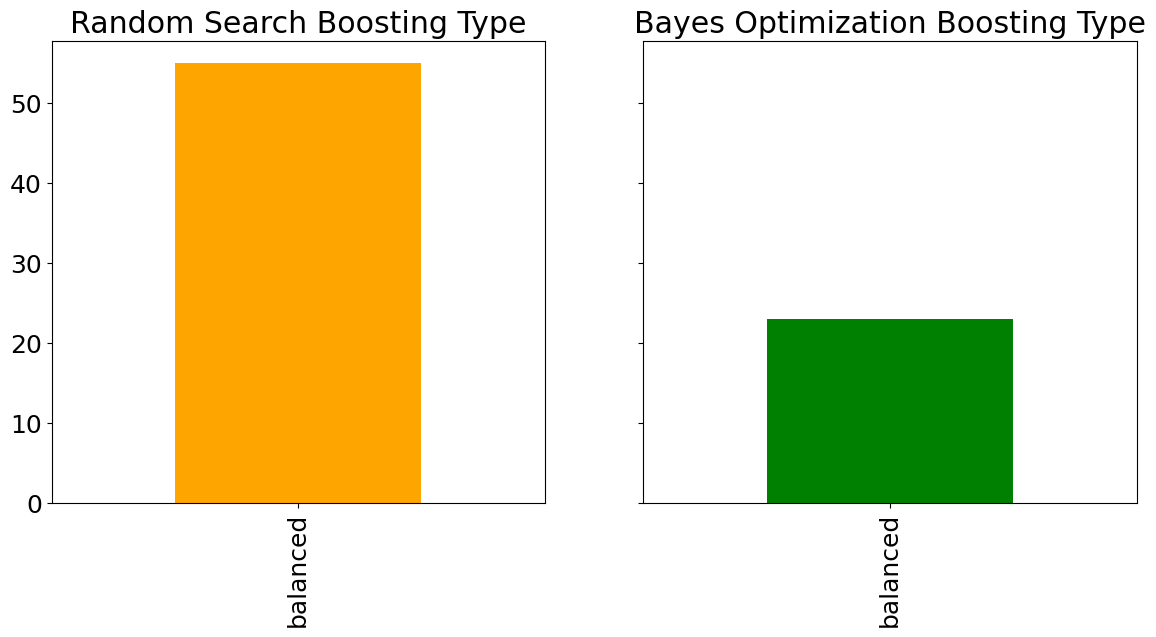

In [47]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['class_weight'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['class_weight'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

Is it unbalance?

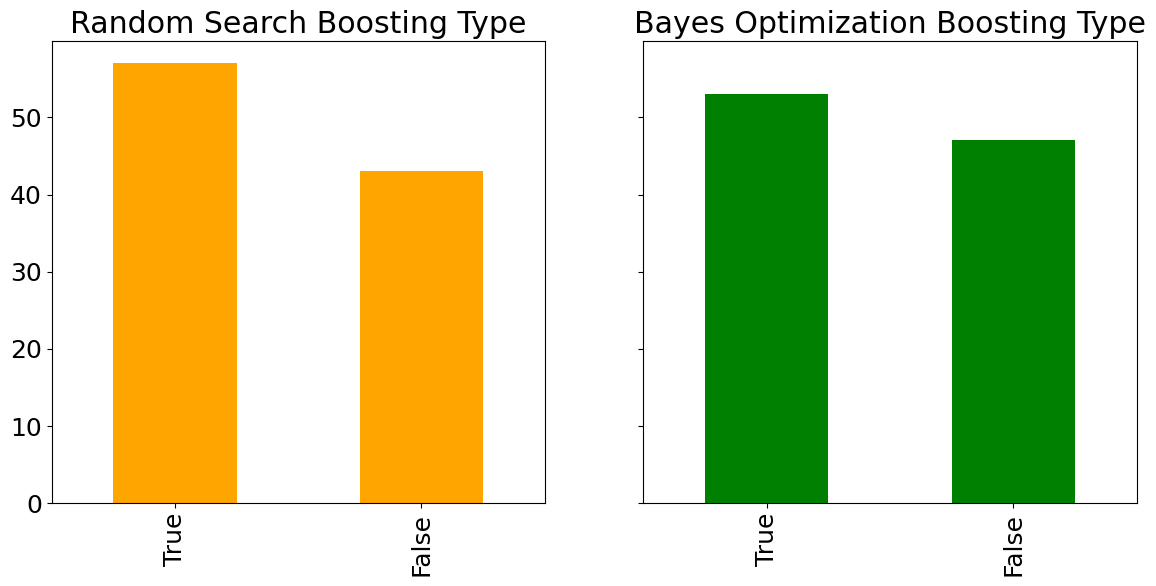

In [48]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['is_unbalance'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['is_unbalance'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

Boosting Type

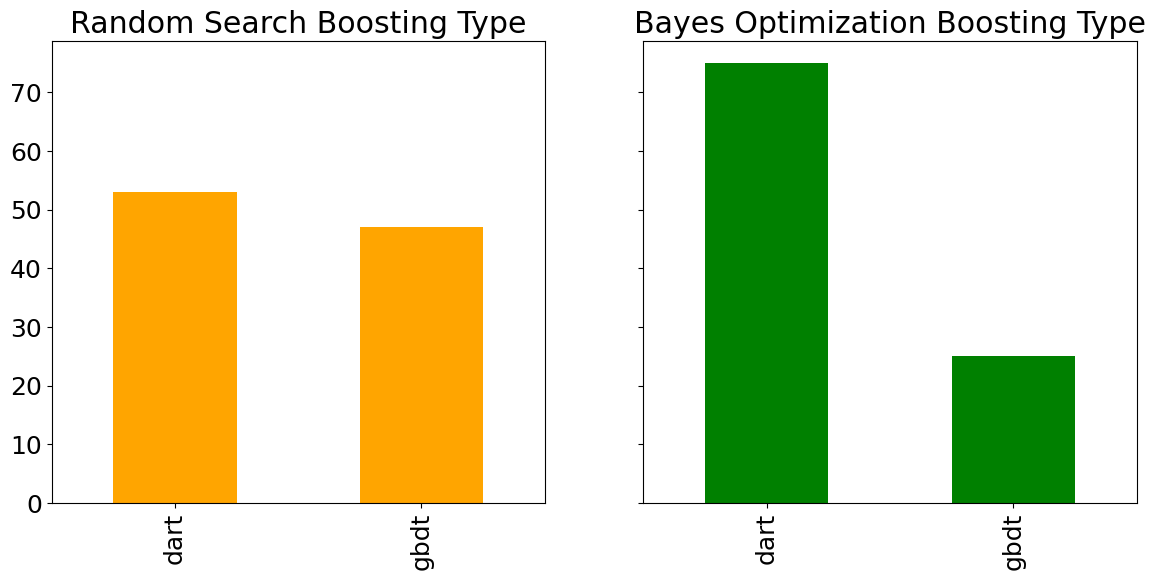

In [49]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

## Plots of All Numeric Hyperparameters

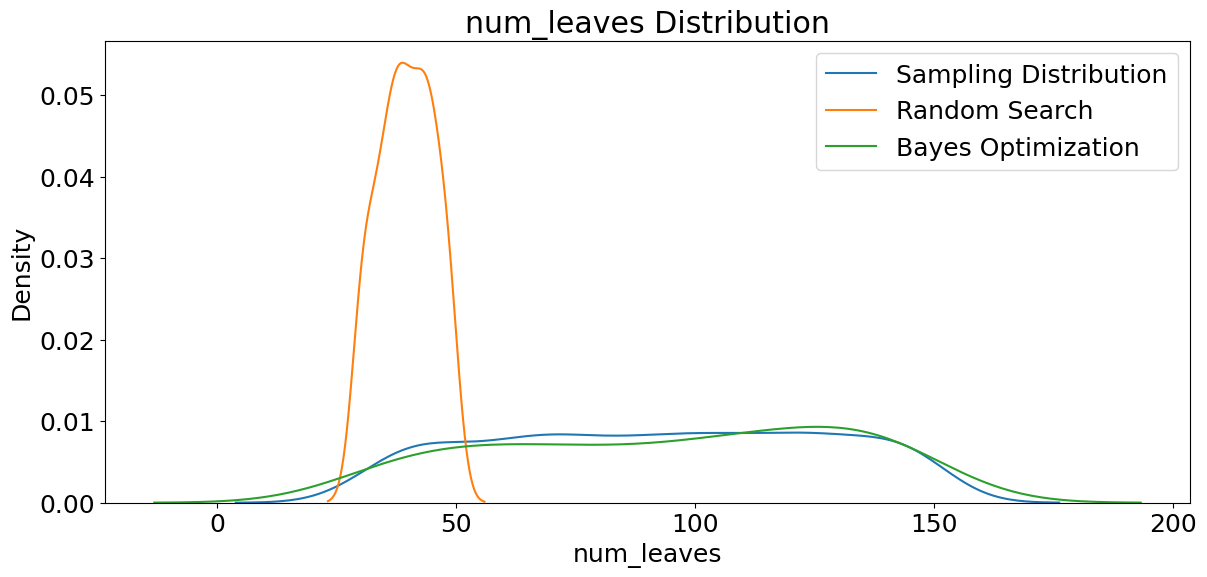

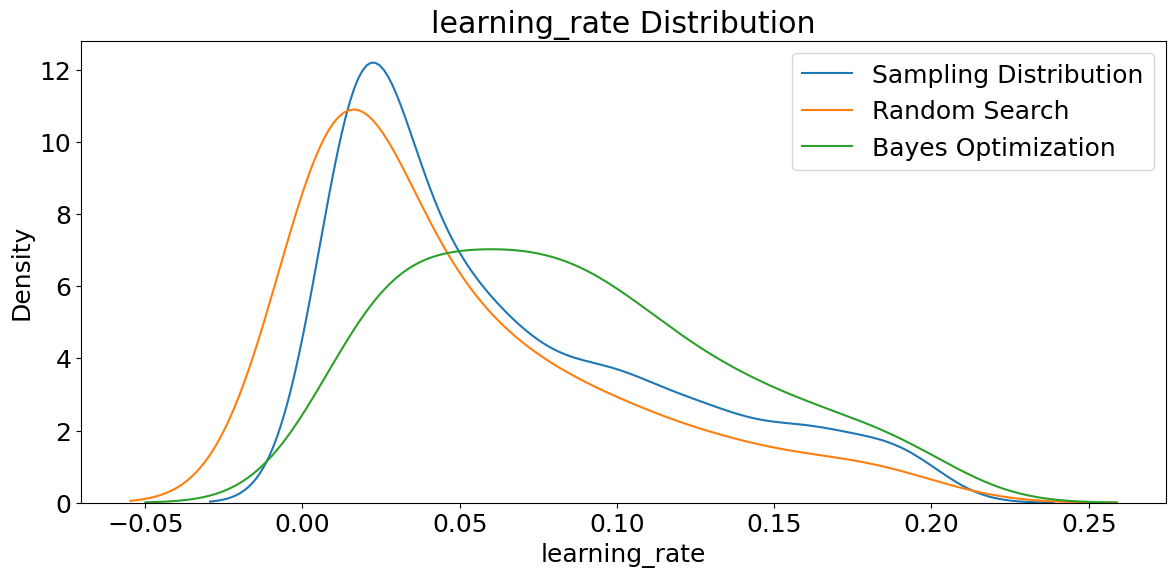

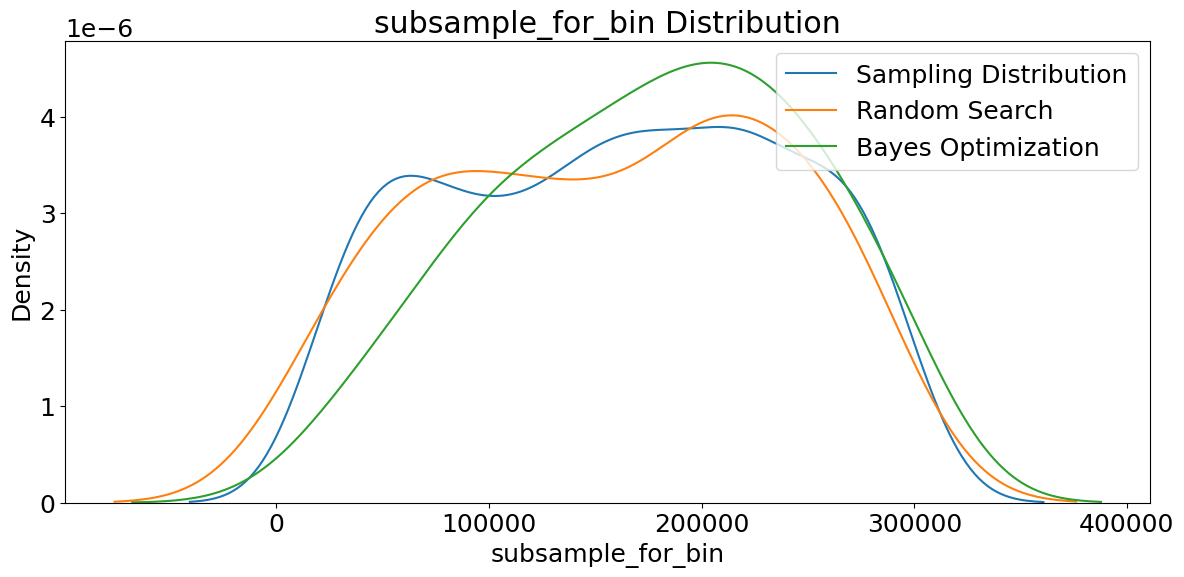

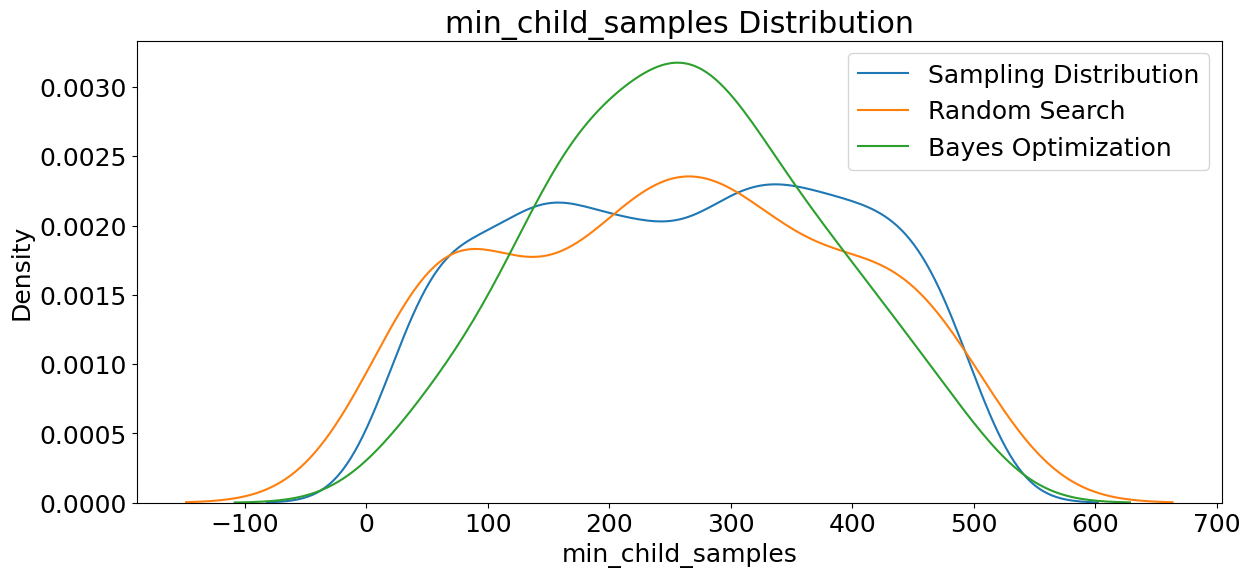

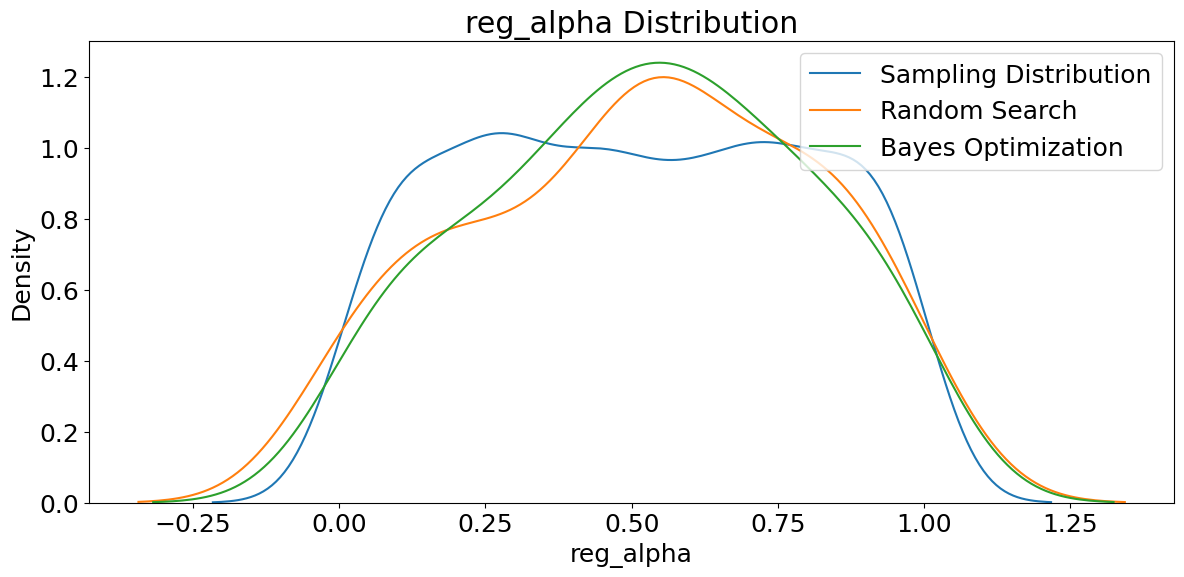

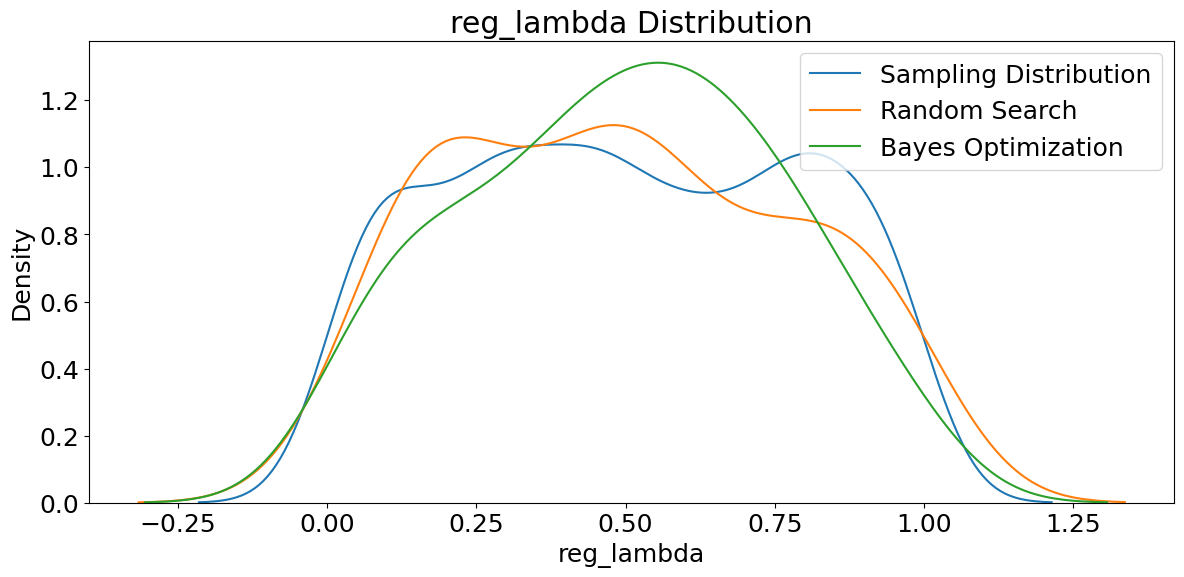

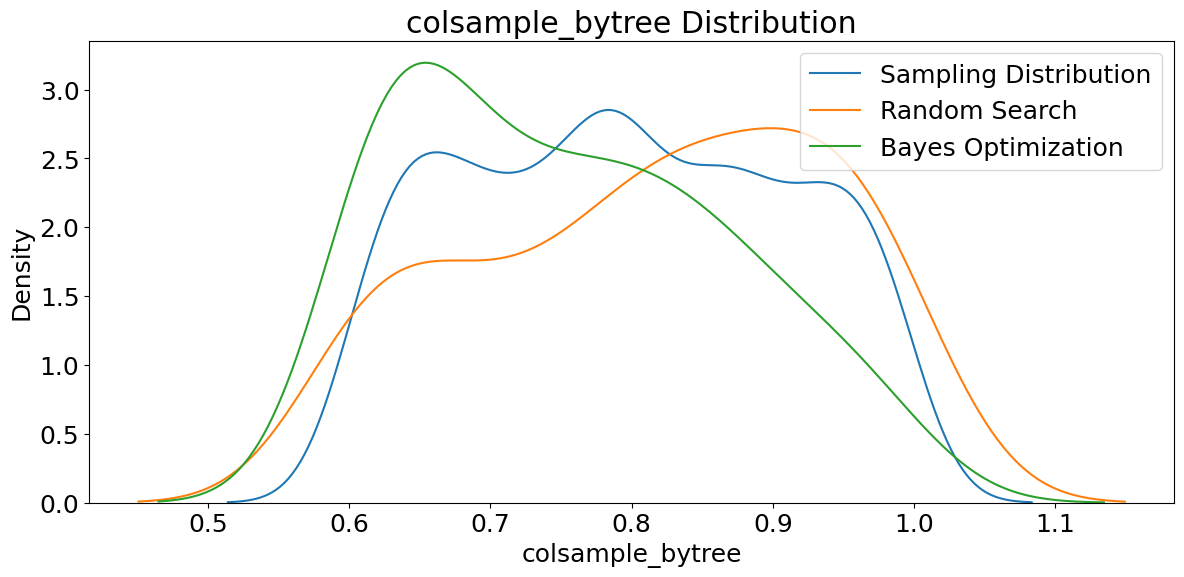

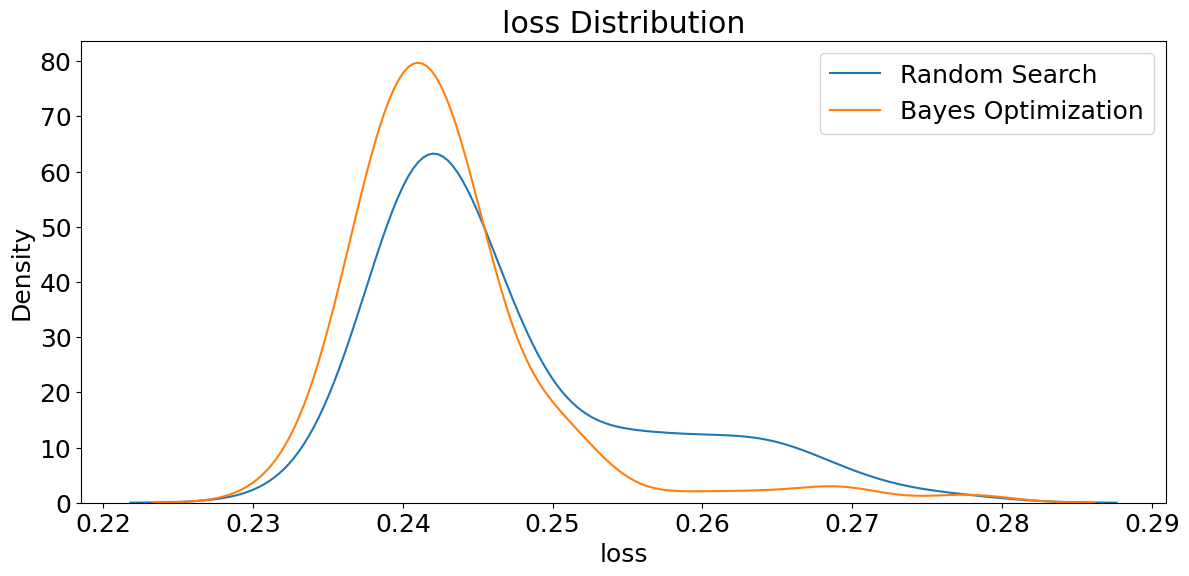

In [50]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'is_unbalance', 'force_row_wise', 'verbose', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

Validation Losses

In [51]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})

scores_aux = pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'})
scores = pd.concat([scores,scores_aux])

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
0,0.767238,99,random
1,0.763848,70,random
2,0.762846,38,random
3,0.762501,31,random
4,0.762479,58,random


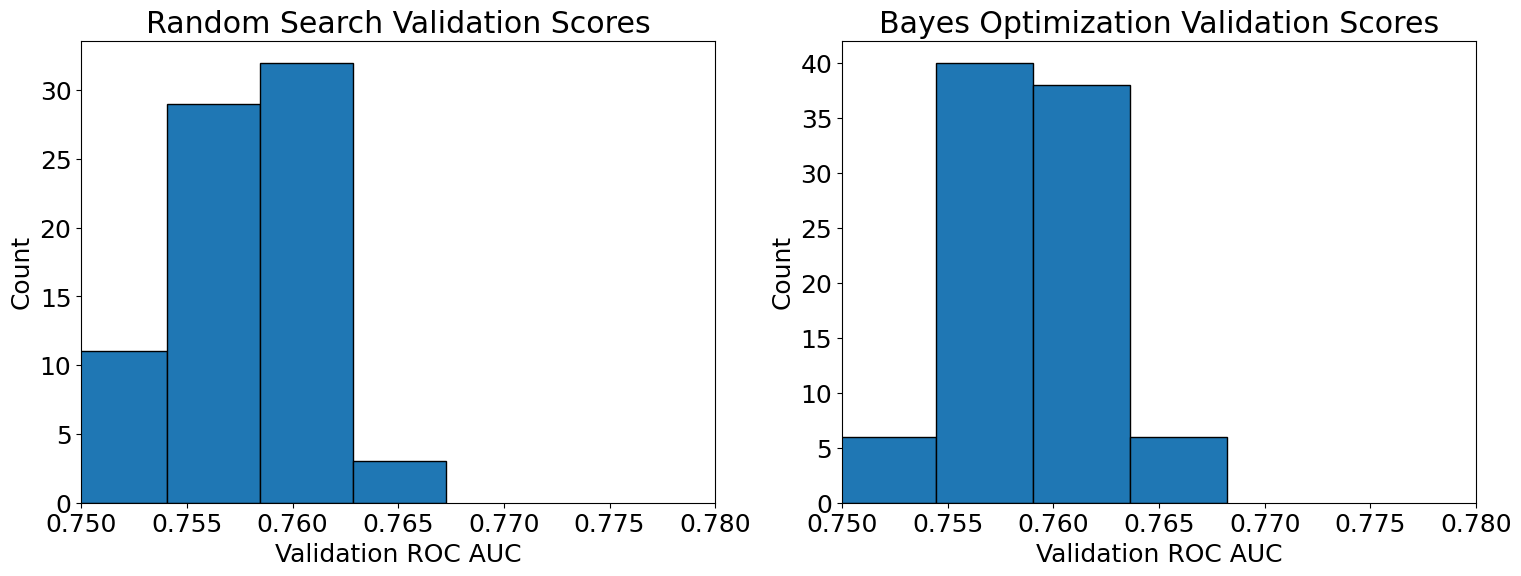

In [52]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

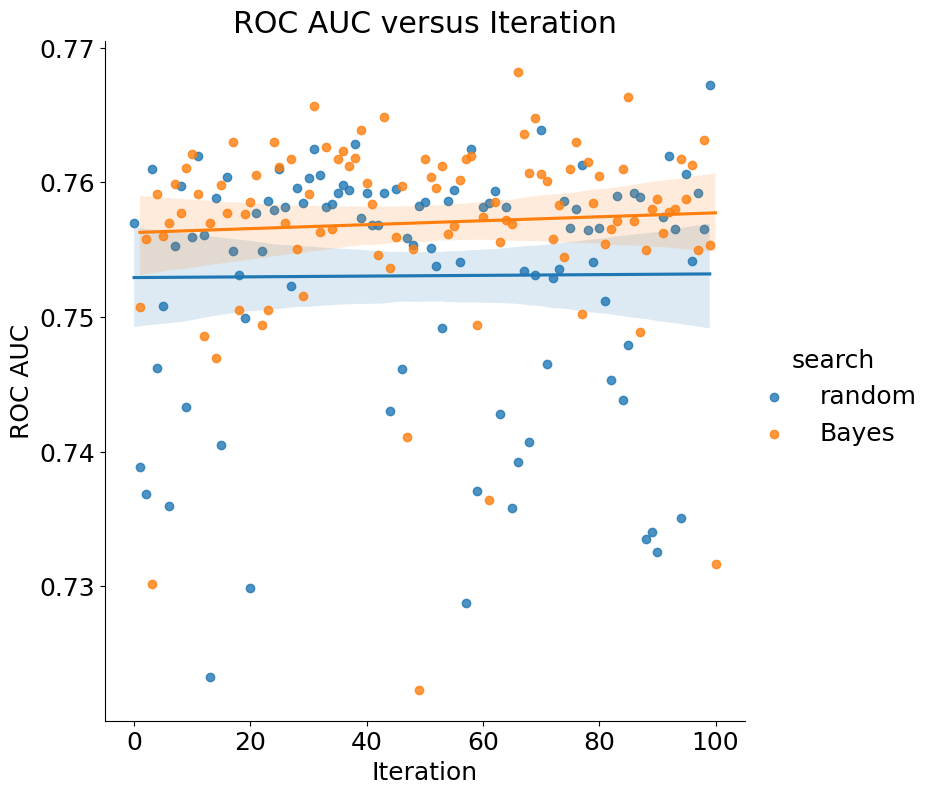

In [53]:
# Plot of scores over the course of searching
sns.lmplot(x='iteration', y='ROC AUC', hue = 'search', data = scores, height = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");